In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.__version__

'2.8.0'

In [4]:
tf.keras.__version__

'2.8.0'

In [5]:
import coco

In [10]:
coco.set_data_dir("data/coco/")

In [12]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data saved to cache-file: data/coco/records_train.pkl


In [13]:
num_images_train = len(filenames_train)
num_images_train

118287

In [14]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data saved to cache-file: data/coco/records_val.pkl


In [15]:
def load_image(path, size=None):

    img = Image.open(path)

    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    img = np.array(img)

    img = img / 255.0

    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [16]:
def show_image(idx, train):

    if train:

        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:

        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(dir, filename)

    for caption in captions:
        print(caption)
    
    img = load_image(path)
    plt.imshow(img)
    plt.show()

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


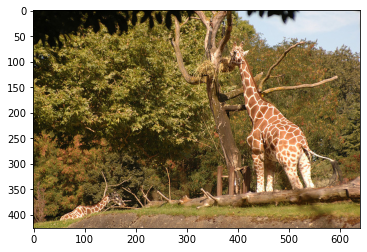

In [18]:
show_image(idx=1, train=True)

In [19]:
image_model = VGG16(include_top=True, weights='imagenet') # download

553476096/553467096 [==============================] - 365s 1us/step


In [20]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
transfer_layer = image_model.get_layer('fc2')

In [22]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [23]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [24]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [25]:
def print_progress(count, max_count):
    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

In [26]:
def process_images(data_dir, filenames, batch_size=32):

    num_images = len(filenames)

    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)

        end_index = start_index + batch_size

        if end_index > num_images:
            end_index = num_images

        current_batch_size = end_index - start_index

        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)

            image_batch[i] = img

        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        start_index = end_index

    print()

    return transfer_values

In [27]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [28]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [30]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Progress: 100.0%
- Data saved to cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 2h 38min 38s


In [31]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Progress: 99.8%
- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 6min 6s


In [32]:
mark_start = 'ssss '
mark_end = ' eeee'

In [33]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [34]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [36]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [38]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [39]:
captions_train_flat = flatten(captions_train_marked)

In [40]:
num_words = 10000

In [41]:
class TokenizerWrap(Tokenizer):
    
    def __init__(self, texts, num_words=None):

        Tokenizer.__init__(self, num_words=num_words)

        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):

        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):

        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [42]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 5.08 s


In [43]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [44]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [45]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 5.49 s


In [46]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [47]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [48]:
def get_random_caption_tokens(idx):

    result = []

    for i in idx:

        j = np.random.choice(len(tokens_train[i]))

        tokens = tokens_train[i][j]

        result.append(tokens)

    return result

In [49]:
def batch_generator(batch_size):

    while True:

        idx = np.random.randint(num_images_train,
                                size=batch_size)

        transfer_values = transfer_values_train[idx]

        tokens = get_random_caption_tokens(idx)

        num_tokens = [len(t) for t in tokens]

        max_tokens = np.max(num_tokens)

        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [50]:
batch_size = 384

In [51]:
generator = batch_generator(batch_size=batch_size)

In [52]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [53]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.209, ..., 0.   , 0.   , 0.486], dtype=float16)

In [54]:
batch_x['decoder_input'][0]

array([   2,    1,  355, 2881,   31,    1,  224,    7,   70,  198,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [55]:
batch_y['decoder_output'][0]

array([   1,  355, 2881,   31,    1,  224,    7,   70,  198,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [56]:
num_captions_train = [len(captions) for captions in captions_train]

In [57]:
total_num_captions_train = np.sum(num_captions_train)

In [58]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1541

In [59]:
state_size = 512

In [60]:
embedding_size = 128

In [61]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [62]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [63]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [64]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [65]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [66]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

In [67]:
def connect_decoder(transfer_values):

    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input

    net = decoder_embedding(net)

    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    decoder_output = decoder_dense(net)
    
    return decoder_output

In [73]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [74]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

In [75]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [77]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [78]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [82]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
[Errno 2] Unable to open file (unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [83]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

Epoch 1/20
1541/1541 [==============================] - ETA: 0s - loss: 1.5432
Epoch 1: saving model to 22_checkpoint.keras
1541/1541 [==============================] - 4630s 3s/step - loss: 1.5432
Epoch 2/20
1541/1541 [==============================] - ETA: 0s - loss: 1.2104 
Epoch 2: saving model to 22_checkpoint.keras
1541/1541 [==============================] - 34546s 22s/step - loss: 1.2104
Epoch 3/20
1541/1541 [==============================] - ETA: 0s - loss: 1.1666
Epoch 3: saving model to 22_checkpoint.keras
1541/1541 [==============================] - 3737s 2s/step - loss: 1.1666
Epoch 4/20
1292/1541 [========================>.....] - ETA: 17:53 - loss: 1.1318

KeyboardInterrupt: 

In [84]:
def generate_caption(image_path, max_tokens=30):

    image = load_image(image_path, size=img_size)

    image_batch = np.expand_dims(image, axis=0)

    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start

    output_text = ''

    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int

        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }


        decoder_output = decoder_model.predict(x_data)

        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)

        sampled_word = tokenizer.token_to_word(token_int)

        output_text += " " + sampled_word

        count_tokens += 1

    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()

    print("Predicted caption:")
    print(output_text)
    print()

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


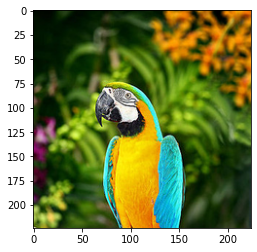

Predicted caption:
 a bird perched on a branch of a tree eeee



In [85]:
generate_caption("images/parrot_cropped1.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


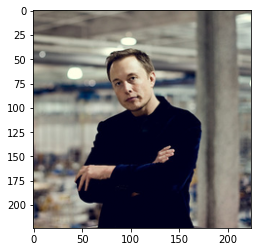

Predicted caption:
 a man in a suit and tie holding a cell phone eeee



In [86]:
generate_caption("images/elon_musk.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


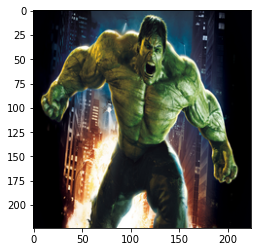

Predicted caption:
 a man is holding a white teddy bear eeee



In [91]:
generate_caption("images/hulk.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


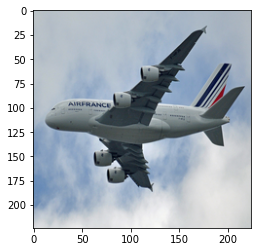

Predicted caption:
 a bird is perched on a wire of a wire eeee



In [92]:
generate_caption("data/coco/train2017/000000000081.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


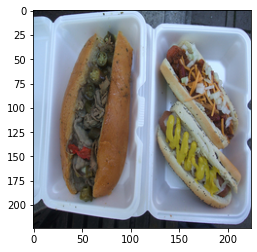

Predicted caption:
 a plate with a sandwich and french fries eeee



In [94]:
generate_caption("data/coco/train2017/000000000321.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


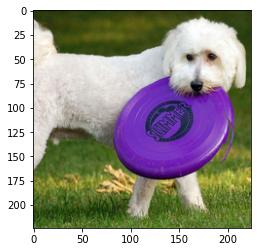

Predicted caption:
 a teddy bear sitting on a chair with a toy eeee



In [95]:
generate_caption("data/coco/train2017/000000000394.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


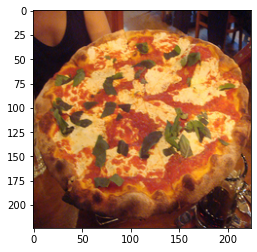

Predicted caption:
 a pizza sitting on top of a pizza pan eeee



In [96]:
generate_caption("data/coco/train2017/000000000397.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


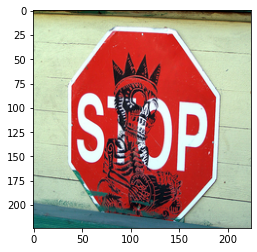

Predicted caption:
 a stop sign with a sticker on it eeee



In [98]:
generate_caption("data/coco/train2017/000000012923.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


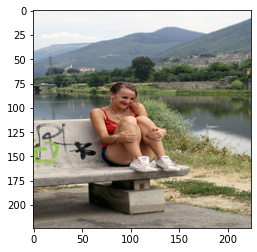

Predicted caption:
 a man is sitting on a bench with a laptop eeee



In [100]:
generate_caption("data/coco/train2017/000000013172.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


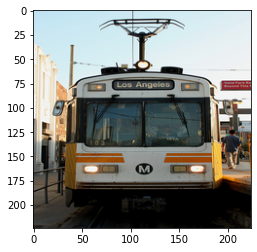

Predicted caption:
 a red double decker bus parked in a parking lot eeee



In [101]:
generate_caption("data/coco/train2017/000000013528.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


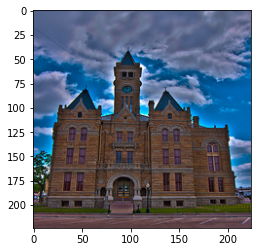

Predicted caption:
 a large clock tower with a clock on top eeee



In [104]:
generate_caption("data/coco/train2017/000000013835.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


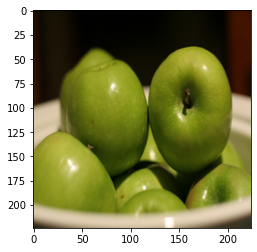

Predicted caption:
 a bowl of fruit and a bowl of fruit eeee



In [109]:
generate_caption("data/coco/val2017/000000002149.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


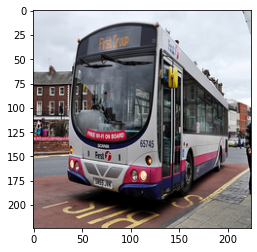

Predicted caption:
 a red double decker bus parked in a lot eeee



In [110]:
generate_caption("data/coco/val2017/000000005037.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


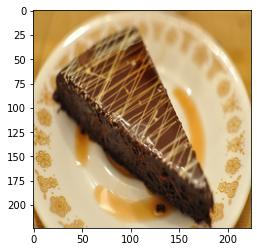

Predicted caption:
 a plate with a piece of cake on it eeee



In [111]:
generate_caption("data/coco/val2017/000000013597.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


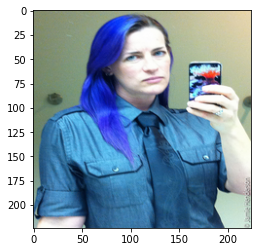

Predicted caption:
 a man in a suit and tie holding a cell phone eeee



In [112]:
generate_caption("data/coco/val2017/000000016598.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


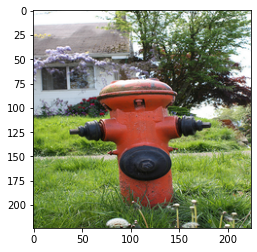

Predicted caption:
 a man is holding a frisbee in a field eeee



In [113]:
generate_caption("data/coco/val2017/000000015746.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


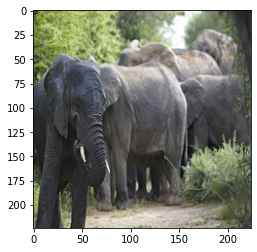

Predicted caption:
 a zebra standing in a field with a tree in the background eeee



In [114]:
generate_caption("data/coco/val2017/000000028449.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


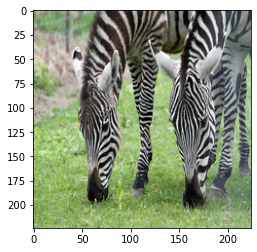

Predicted caption:
 a zebra standing in a field with a tree in the background eeee



In [116]:
generate_caption("data/coco/val2017/000000038825.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


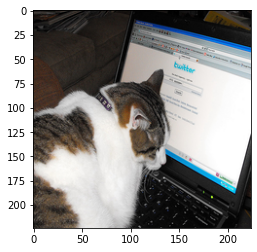

Predicted caption:
 a cat is sitting on a laptop keyboard eeee



In [117]:
generate_caption("data/coco/val2017/000000051008.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


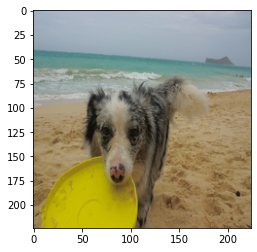

Predicted caption:
 a dog is sitting on a couch with a toy in its mouth eeee



In [118]:
generate_caption("data/coco/val2017/000000052891.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


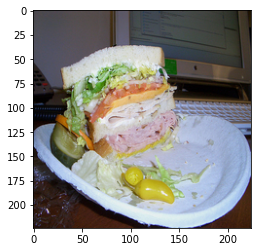

Predicted caption:
 a plate with a sandwich and french fries on it eeee



In [121]:
generate_caption("data/coco/val2017/000000056288.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


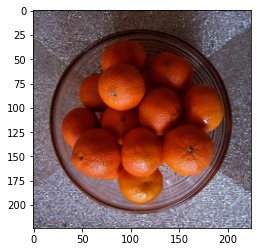

Predicted caption:
 a bowl of soup and a bowl of soup eeee



In [119]:
generate_caption("data/coco/val2017/000000050896.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


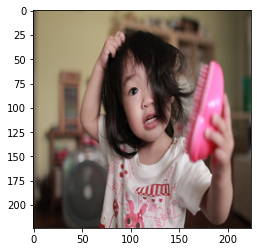

Predicted caption:
 a man in a suit and tie holding a cell phone eeee



In [123]:
generate_caption("data/coco/val2017/000000066886.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


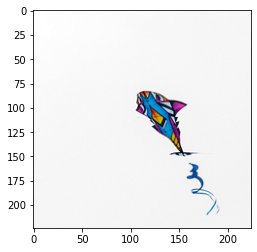

Predicted caption:
 a man is flying a kite in the sky eeee



In [124]:
generate_caption("data/coco/val2017/000000085665.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


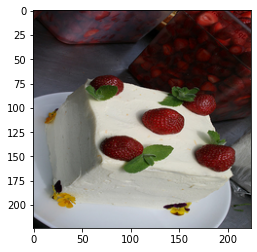

Predicted caption:
 a plate with a sandwich and french fries eeee



In [130]:
generate_caption("data/coco/val2017/000000098633.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


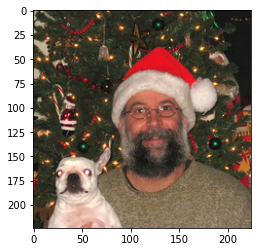

Predicted caption:
 a man holding a white frisbee in his right hand eeee



In [131]:
generate_caption("data/coco/val2017/000000117525.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


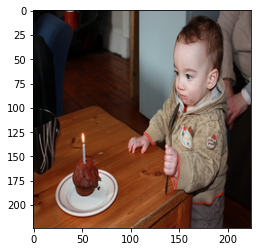

Predicted caption:
 a man in a suit and tie holding a cell phone eeee



In [132]:
generate_caption("data/coco/val2017/000000117425.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


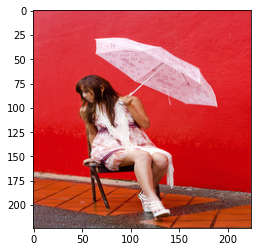

Predicted caption:
 a baseball player is swinging a bat at a ball eeee



In [133]:
generate_caption("data/coco/val2017/000000122046.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


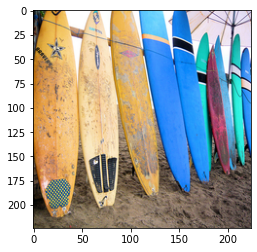

Predicted caption:
 a bunch of bananas hanging from a ceiling eeee



In [136]:
generate_caption("data/coco/val2017/000000127517.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


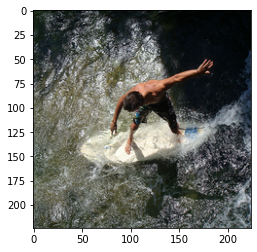

Predicted caption:
 a man is surfing on a wave in the ocean eeee



In [137]:
generate_caption("data/coco/val2017/000000122672.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


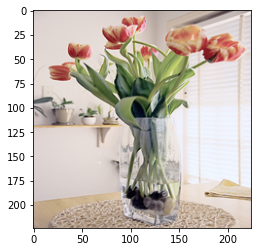

Predicted caption:
 a vase filled with flowers sitting on a table eeee



In [138]:
generate_caption("data/coco/val2017/000000140439.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


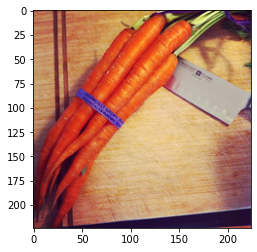

Predicted caption:
 a person holding a cell phone in their hand eeee



In [139]:
generate_caption("data/coco/val2017/000000143998.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


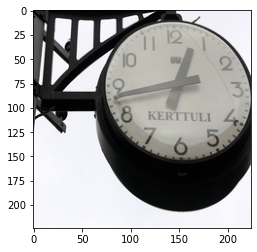

Predicted caption:
 a clock on a pole with a clock on it eeee



In [140]:
generate_caption("data/coco/val2017/000000140929.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


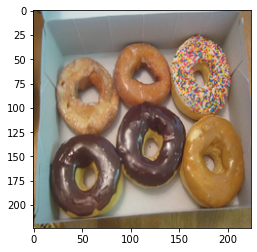

Predicted caption:
 a bowl of fruit and a bowl of fruit eeee



In [142]:
generate_caption("data/coco/val2017/000000148957.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


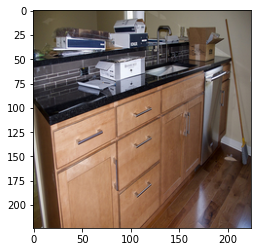

Predicted caption:
 a kitchen with a stove and a microwave eeee



In [143]:
generate_caption("data/coco/val2017/000000165257.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


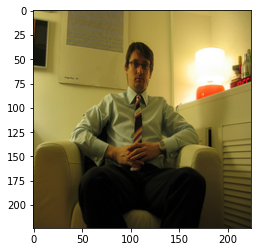

Predicted caption:
 a man is sitting on a couch with a laptop eeee



In [149]:
generate_caption("data/coco/val2017/000000172877.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


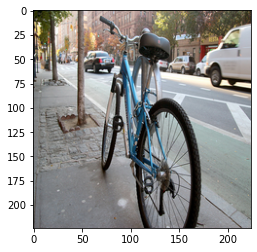

Predicted caption:
 a man is riding a bike down a street eeee



In [154]:
generate_caption("data/coco/val2017/000000174482.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


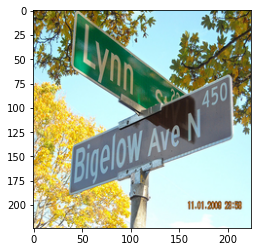

Predicted caption:
 a street sign with a sticker on it eeee



In [155]:
generate_caption("data/coco/val2017/000000173183.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


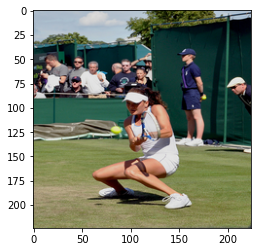

Predicted caption:
 a man in a green shirt and helmet is playing tennis eeee



In [156]:
generate_caption("data/coco/val2017/000000179487.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


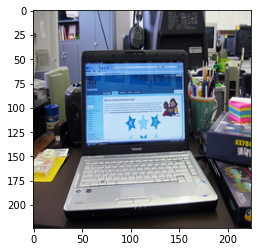

Predicted caption:
 a laptop computer sitting on top of a desk eeee



In [159]:
generate_caption("data/coco/val2017/000000178469.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


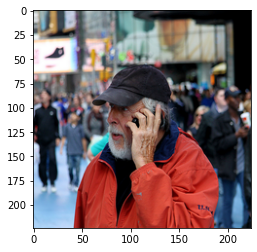

Predicted caption:
 a man and woman are playing a video game eeee



In [160]:
generate_caption("data/coco/train2017/000000000395.jpg")

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


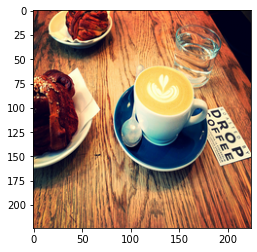

Predicted caption:
 a plate with a sandwich and a cup of coffee eeee



In [163]:
generate_caption("data/coco/train2017/000000000605.jpg")

In [167]:
generate_caption_coco("data/coco/val2017/000000000139.jpg")

TypeError: tuple indices must be integers or slices, not str

In [ ]:
generate_caption("data/coco/val2017/000000000139.jpg")

In [ ]:
generate_caption("data/coco/val2017/000000165257.jpg")

In [ ]:
generate_caption("data/coco/val2017/000000165257.jpg")

In [ ]:
generate_caption("data/coco/val2017/000000165257.jpg")

In [168]:
def generate_caption_coco(idx, train=False):

    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)

    generate_caption(image_path=path)

    print("True captions:")
    for caption in captions:
        print(caption)

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


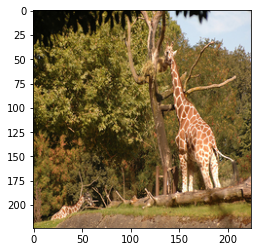

Predicted caption:
 a giraffe standing in a field with trees in the background eeee

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [169]:
generate_caption_coco(idx=1, train=True)

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


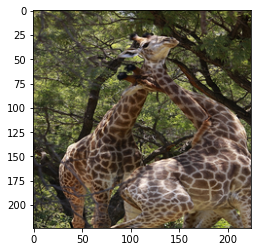

Predicted caption:
 a close up of a pizza on a plate eeee

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [89]:
generate_caption_coco(idx=10, train=True)

C:\Users\Acer\AppData\Local\Temp/ipykernel_5180/750584796.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)


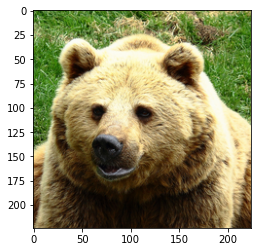

Predicted caption:
 a dog is sitting on a couch with a cat eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [90]:
generate_caption_coco(idx=1, train=False)